Plot the CCDF edge weight distribution of this network. Calculate its average and standard deviation. NOTE: this is a directed graph!

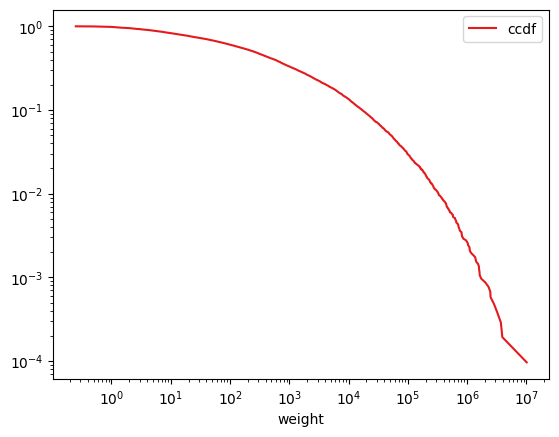

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# Load the data
G = nx.read_edgelist("data.txt", data = [("weight", float),], create_using = nx.DiGraph())

# Get the weights
edgeweights = list(dict(nx.get_edge_attributes(G, "weight")).values())

# Let's use our degree CCDF code for the edge weights
wd = pd.DataFrame(list(Counter(edgeweights).items()), columns = ("weight", "count")).sort_values(by = "weight")
ccdf = wd.sort_values(by = "weight", ascending = False)
ccdf["cumsum"] = ccdf["count"].cumsum()
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
ccdf = ccdf[["weight", "ccdf"]].sort_values(by = "weight")
ccdf.plot(kind = "line", x = "weight", y = "ccdf", color = "#e41a1c", loglog = True)
plt.show()

In [2]:
# Average & stdev of the weights
edgeweights = np.array(edgeweights)
print("Edge weight average: %1.4f" % np.mean(edgeweights))
print("Edge weight stdev: %1.4f" % np.std(edgeweights))

Edge weight average: 17191.3325
Edge weight stdev: 149924.3810


What is the minimum statistically significant edge weight (the one two standard deviations higher than the average) of the network from Exercise 24.1? How many edges would you keep if you were to set that as the threshold?

In [3]:
# Calculate average & stdev
edgeweights = np.array(edgeweights)
avg = np.mean(edgeweights)
std = np.std(edgeweights)

In [4]:
# Minimum threshold weight
threshold = avg + (2 * std)
print("Minimum threshold: %1.1f" % threshold)

Minimum threshold: 317040.1


In [5]:
# Counting edges above the threshold
edges_kept = 0
for e in G.edges(data = True):
   if e[2]["weight"] >= threshold:
      edges_kept += 1

print("Edges kept: %d" % edges_kept)
# Not that many!

Edges kept: 107


Can you calculate the doubly stochastic adjacency matrix of the network from Exercise 24.1? Does the calculation eventually converge? (Limit the normalization attempts to 1,000. If by 1,000 normalizations you don't have a doubly stochastic matrix, the calculation didn't converge)

In [6]:
# Let's start by getting the adjacency matrix
A = nx.to_numpy_matrix(G)

In [7]:
# If we want to get the doubly stochastic, we need to alternatively
# normalize by row and column sum. We stop only when the deviation
# from one is very little, thus the row/column sum is very close to
# one. We also need to keep track of how many times we performed
# the normalization. If we keep going back and forth between the
# same two values, it means we're not converging.
attempts = 0
row_sums = A.sum(axis = 1)
while np.std(A.sum(axis = 1)) > 1e-12:
   A /= A.sum(axis = 1)
   A /= A.sum(axis = 0)
   attempts += 1
   if attempts > 1000:
      print("Calculation didn't converge. The matrix cannot be made doubly stochastic. Aborting.")
      break

print("Calculation converged. Here's A:")
print(A)
# YES! Calculation converges! Phew!

Calculation converged. Here's A:
[[0.00000000e+00 9.29197199e-07 9.75734853e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.73760713e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.46183715e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 4.05688025e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.59041160e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.32560627e-06 3.66899981e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


How many edges would you keep in the network from Exercise 24.1 if you were to return the doubly stochastic backbone including all nodes in the network in a single (weakly) connected component with the minimum number of edges?

In [11]:
# Load the data
G = nx.read_edgelist("data.txt", data = [("weight", float),], create_using = nx.DiGraph())
original_nodes = len(G.nodes)

In [8]:
# Let's make the adjacency matrix doubly stochastic
attempts = 0
A = nx.to_numpy_matrix(G)
row_sums = A.sum(axis = 1)
while np.std(A.sum(axis = 1)) > 1e-12:
   A /= A.sum(axis = 1)
   A /= A.sum(axis = 0)
   attempts += 1
   if attempts > 1000:
      print("Calculation didn't converge. The matrix cannot be made doubly stochastic. Aborting.")
      break

In [9]:
# For convenience, let's make it into a pandas dataframe
df = pd.DataFrame(A).unstack().reset_index()
df.columns = ("source", "target", "weight")
df = df[df["weight"] > 0]

In [12]:
# We make an empty graph
G = nx.DiGraph()

# We sort edge weights in descending weight order
df = df.sort_values(by = "weight", ascending = False)

# Now we add one edge at a time. We stop when all nodes have at least one edge and they are all
# part of the same (weakly) connected component
i = 0
while nx.number_weakly_connected_components(G) != 1 or nx.number_of_nodes(G) < original_nodes:
   edge = df.iloc[i]
   G.add_edge(edge["source"], edge["target"], weight = edge["weight"])
   i += 1

print("Edges kept: %d" % len(G.edges))
# A bit better than naive thresholding!

Edges kept: 377
